# Seamless Image Cloning (Geometric)

The purpose of this code is to demonstrate the seamless image cloning algorithm. See [1] for details. To solve the sparse least-squares problem resulting from the algorithm in [1], we use a geometric Jacobi method inspired by [2].

[1] http://www.cs.jhu.edu/~misha/Fall07/Papers/Perez03.pdf

[2] http://http.developer.nvidia.com/GPUGems/gpugems_ch38.html

## compute naive clone

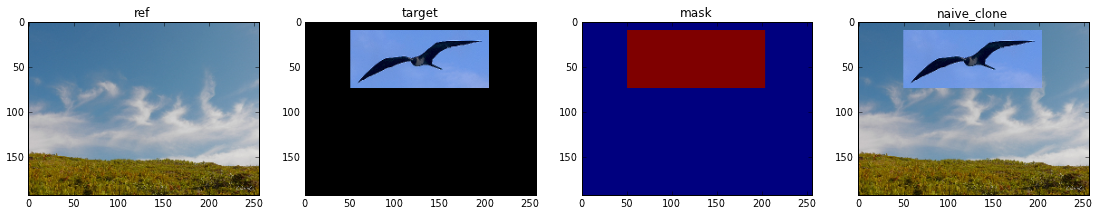

In [1]:
import PIL
import PIL.Image
import scipy
import scipy.misc

ref = PIL.Image.open("sky.jpg")
ref = numpy.array(ref)
ref = scipy.misc.imresize(ref, 0.25, interp="bicubic")

target                        = PIL.Image.open("bird.jpg")
target                        = numpy.array(target)
target                        = scipy.misc.imresize(target, 0.25, interp="bicubic")
target_array_rgb              = numpy.array(target)
target_array_rgb_resized      = scipy.misc.imresize(target, 0.5, interp="bicubic")

rny = ref.shape[0]
rnx = ref.shape[1]
tny = target_array_rgb_resized.shape[0]
tnx = target_array_rgb_resized.shape[1]
oy  = 10
ox  = 50
#oy  = 50
#ox  = 250

target_array_rgb_resized_view = target_array_rgb_resized.view(dtype=[("r", numpy.uint8), ("g", numpy.uint8), ("b", numpy.uint8)]).squeeze()
zeros                         = numpy.zeros_like(ref)
zeros_view                    = zeros.view(dtype=[("r", numpy.uint8), ("g", numpy.uint8), ("b", numpy.uint8)]).squeeze()
target                        = zeros_view.copy()
target[oy:oy+tny, ox:ox+tnx]  = target_array_rgb_resized_view
target                        = numpy.reshape(target.view(dtype=numpy.uint8), ref.shape)

mask                       = numpy.zeros((rny,rnx), dtype=numpy.uint8)
mask[oy:oy+tny, ox:ox+tnx] = 1

naive_clone                = ref.copy()
naive_clone[mask == 1]     = target[mask == 1]



figsize(19,4)

matplotlib.pyplot.subplot(141)
matplotlib.pyplot.imshow(ref);
matplotlib.pyplot.title("ref");

matplotlib.pyplot.subplot(142)
matplotlib.pyplot.imshow(target);
matplotlib.pyplot.title("target");

matplotlib.pyplot.subplot(143)
matplotlib.pyplot.imshow(mask);
matplotlib.pyplot.title("mask");

matplotlib.pyplot.subplot(144)
matplotlib.pyplot.imshow(naive_clone);
matplotlib.pyplot.title("naive_clone");

## compute strict interior and border regions

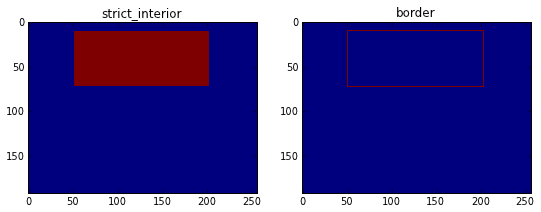

In [3]:
import skimage
import skimage.morphology

strict_interior            = skimage.morphology.erosion(mask, numpy.ones((3,3), dtype=numpy.uint8))
strict_interior_indices    = strict_interior.nonzero()
num_strict_interior_pixels = strict_interior_indices[0].shape[0]
border                     = mask - strict_interior



figsize(9,4)

matplotlib.pyplot.subplot(121);
matplotlib.pyplot.imshow(strict_interior, interpolation="nearest");
matplotlib.pyplot.title("strict_interior");

matplotlib.pyplot.subplot(122);
matplotlib.pyplot.imshow(border, interpolation="nearest");
matplotlib.pyplot.title("border");

## compute seamless clone (red)

In [32]:
import scipy
import scipy.sparse
import scipy.sparse.linalg

ref_greyscale    = ref[:,:,0].copy()
target_greyscale = target[:,:,0].copy()

X_current              = numpy.zeros_like(mask, dtype=numpy.float32)
X_next                 = numpy.zeros_like(mask, dtype=numpy.float32)
X_current[border == 1] = ref_greyscale[border == 1]
X_next[border == 1]    = ref_greyscale[border == 1]

num_iterations  = 1500
print_frequency = 25

for n in range(num_iterations):

    if n % print_frequency == 0:
        print n
        seamless_clone_greyscale = ref_greyscale.copy()
        seamless_clone_greyscale[strict_interior_indices] = X_current[strict_interior_indices]
        scipy.misc.imsave("%d.png" % n,  seamless_clone_greyscale / 255.0)
        
    for i in range(num_strict_interior_pixels):

        y = strict_interior_indices[0][i]
        x = strict_interior_indices[1][i]

        x_right = x+1
        x_left  = x-1
    
        y_up    = y-1
        y_down  = y+1

        x_neighbors = []
        y_neighbors = []

        if x_right < rnx:
            y_neighbors.append(y)
            x_neighbors.append(x_right)

        if y_up >= 0:
            y_neighbors.append(y_up)
            x_neighbors.append(x)

        if x_left >= 0:
            y_neighbors.append(y)
            x_neighbors.append(x_left)

        if y_down < rny:
            y_neighbors.append(y_down)
            x_neighbors.append(x)

        y_neighbors               = numpy.array(y_neighbors)
        x_neighbors               = numpy.array(x_neighbors)
        strict_interior_neighbors = (strict_interior[(y_neighbors,x_neighbors)] == 1).nonzero()
        border_neighbors          = (strict_interior[(y_neighbors,x_neighbors)] == 0).nonzero()
        num_neighbors             = y_neighbors.shape[0]

        sum_X_current_strict_interior_neighbors = numpy.sum(X_current[(y_neighbors[strict_interior_neighbors],x_neighbors[strict_interior_neighbors])])
        sum_vq       = (num_neighbors * target_greyscale[y,x]) - numpy.sum(target_greyscale[(y_neighbors, x_neighbors)])
        sum_border_f = numpy.sum(ref_greyscale[(y_neighbors[border_neighbors],x_neighbors[border_neighbors])])

        X_xy_next    = (sum_X_current_strict_interior_neighbors + sum_border_f + sum_vq) / num_neighbors
        X_next[y,x]  = numpy.clip(X_xy_next, 0.0, 255.0)

        #if i == 0:
        #    print "-"
        #    print ref_greyscale[(y_neighbors[border_neighbors],x_neighbors[border_neighbors])]
        #    print X_current[(y_neighbors,x_neighbors)]
        #    print "-"
        #    print sum_X_current_strict_interior_neighbors
        #    print sum_vq
        #    print sum_border_f
        #    print X_current[y,x]
        #    print X_xy_next
        #    print 
        
    #print "----"
    X_current, X_next = X_next, X_current

0
25
50
75
100
125
150
175
200
225
250
275
300
325
350
375
400
425
450
475
500
525
550
575
600
625
650
675
700
725
750
775
800
825
850
875
900
925
950
975
1000
1025
1050
1075
1100
1125
1150
1175
1200
1225
1250
1275
1300
1325
1350
1375
1400
1425
1450
1475


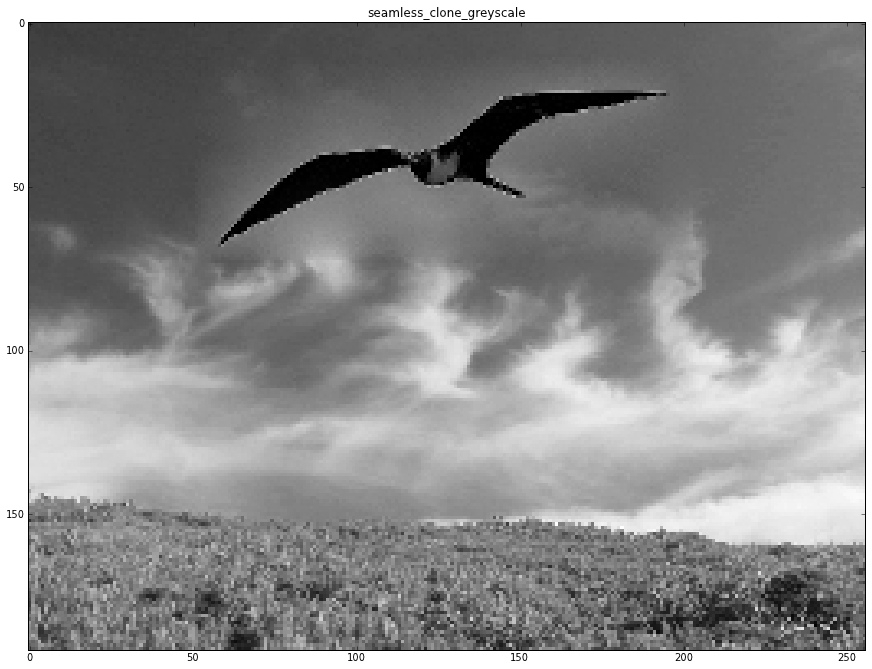

In [33]:
seamless_clone_greyscale                          = ref_greyscale.copy()
seamless_clone_greyscale[strict_interior_indices] = X_current[strict_interior_indices]



figsize(15,15)

matplotlib.pyplot.imshow(seamless_clone_greyscale, interpolation="nearest", cmap="gray");
matplotlib.pyplot.title("seamless_clone_greyscale");